<a href="https://colab.research.google.com/github/Lcocks/DS6050-DeepLearning/blob/main/8_live_Coding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CONFIGURATION:
Vocabulary Size: 20 (+3 special tokens)
Hidden Dimension: 32 (The Bottleneck!)
Long Sequence Length: 20

SECTION 1: The Reverse Task - Stressing the Bottleneck

Example (Short):
  Source (Input):      [3, 8, 17, 15, 7]
  Decoder Input (SOS+):[21, 7, 15, 17, 8, 3]
  Decoder Output (+EOS):[7, 15, 17, 8, 3, 22]

Key challenge: Compressing 20 tokens into 32 numbers and reversing them.

SECTION 2: Vanilla Seq2Seq - Everything through ONE vector

SECTION 3: Attention - Learning WHERE to Look (The Learned Kernel)

SECTION 4: Training Both Models (Using Teacher Forcing)

Training on SHORT sequences (length 5)...
Training Vanilla Seq2Seq:
  Epoch   1/30: Loss = 2.8487, Token Acc (TF) = 23.2%
  Epoch  10/30: Loss = 0.5913, Token Acc (TF) = 84.0%
  Epoch  20/30: Loss = 0.2283, Token Acc (TF) = 95.0%
  Epoch  30/30: Loss = 0.1159, Token Acc (TF) = 97.9%
  Training finished in 8.89 seconds.

Training Attention Seq2Seq:
  Epoch   1/30: Loss = 2.6861, Token Acc (TF) = 21.9%
  Epoch  10

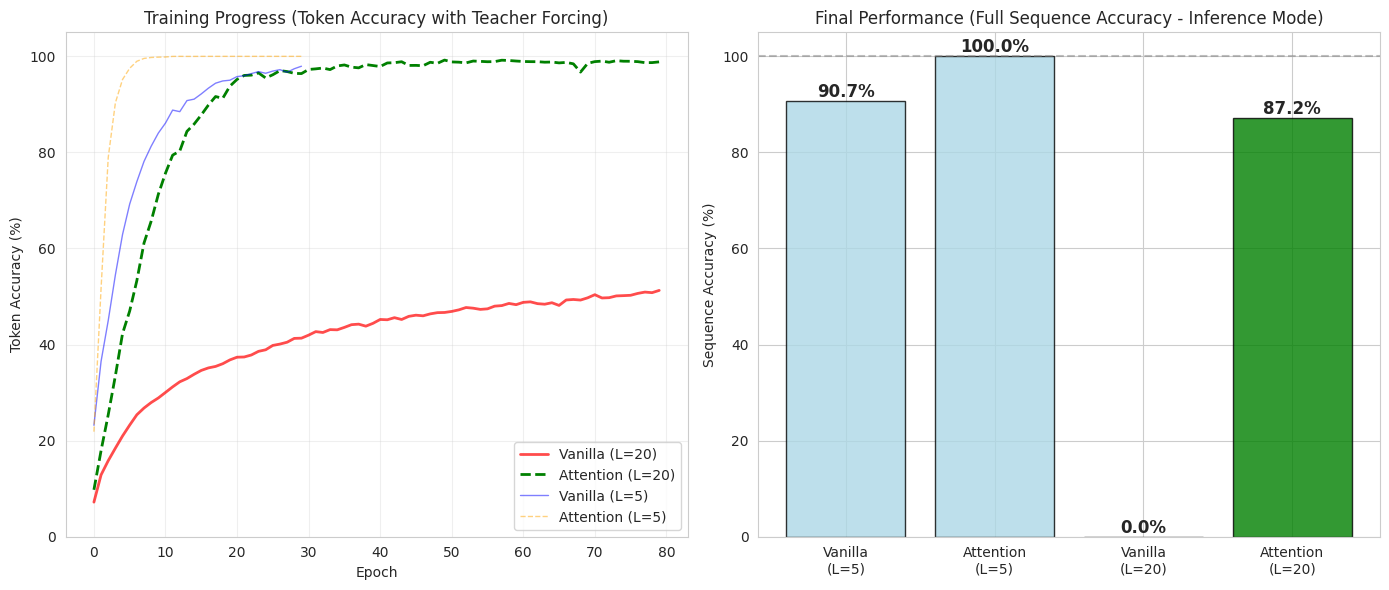

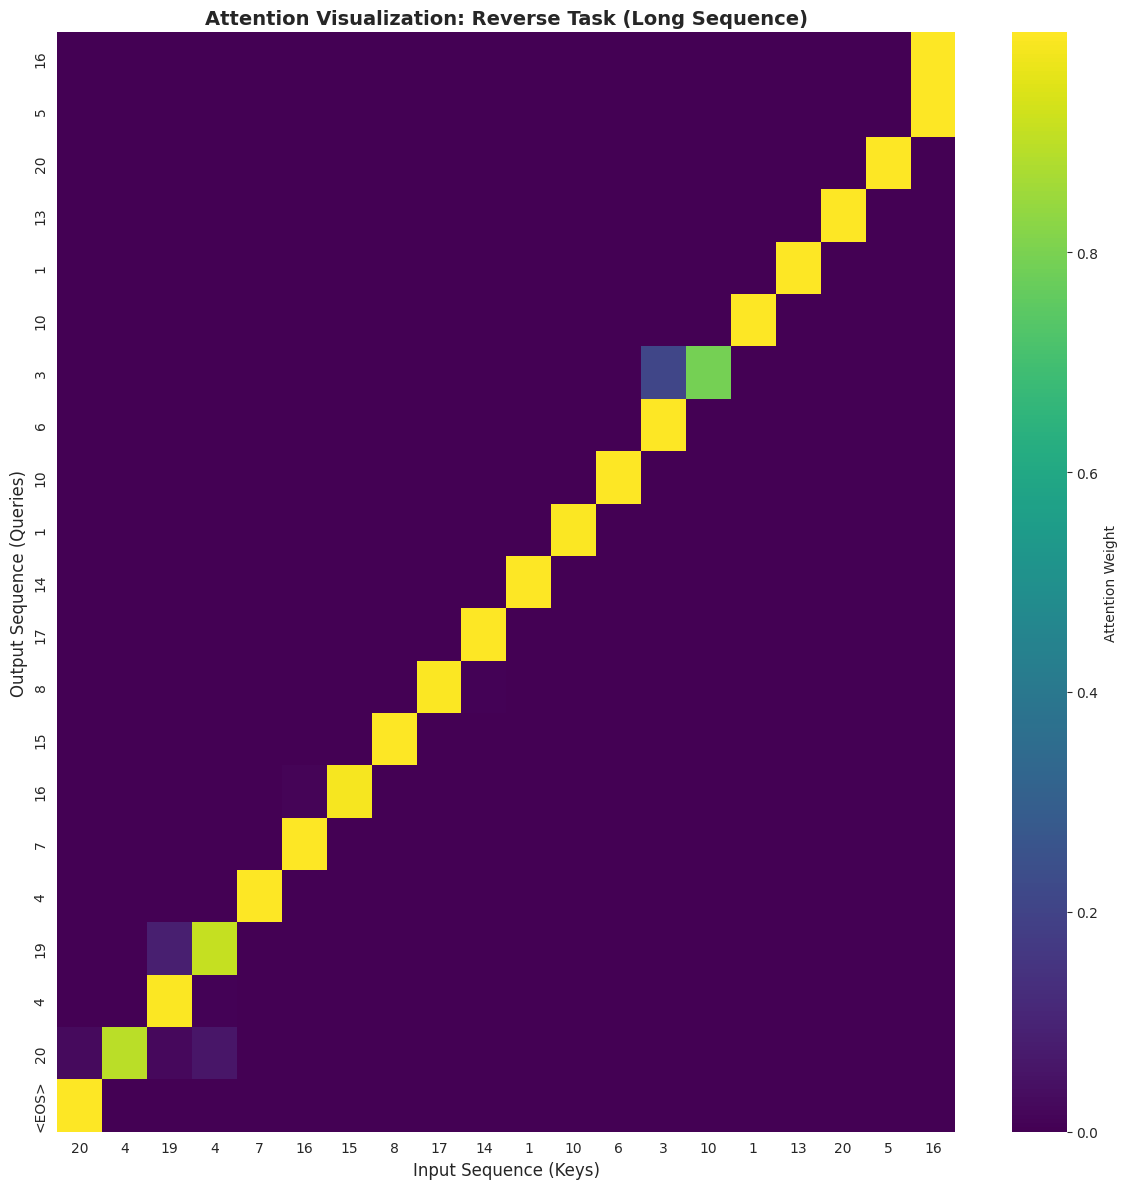

In [ ]:
"""
Attention Mechanisms: Live Lecture Demonstration
==============================================================================

  1) A vanilla encoder–decoder (Seq2Seq) with a SINGLE context vector (bottleneck)
  2) A Seq2Seq with Scaled Dot-Product Attention (learned kernel)

We use a minimal REVERSE task:
    input  x = [x1, x2, ..., xT]
    target y = [xT, x_{T-1}, ..., x1, <EOS>]

Why reverse? Because the FIRST output depends on the LAST input — i.e., long-range dependency.
This stresses the fixed-size bottleneck and showcases how attention removes it.

• Attention is data pooling with learned similarity:
    α_i(q) = softmax(a(q, k_i))              # weights
    context(q) = Σ_i α_i(q) v_i               # weighted sum

• Scaled dot-product attention:
    a(q, k_i) = (Q^T K_i) / sqrt(d_k)

We measure:
  - Token accuracy during TRAINING (teacher forcing) to show optimization
  - Full sequence accuracy during INFERENCE (greedy decoding) to show end-to-end success

L = 5  vs  L = 20  (only the sequence length differs)
-----------------------------------------------------
L=5   : vanilla may still cope — the 32-dim bottleneck can “memorize” short sequences.
L=20  : vanilla typically fails — the single 32-dim vector cannot reliably preserve order/content
        across 20 tokens; gradients also must traverse long paths → vanishing/exposure-bias issues.
Attention removes this by giving the decoder DIRECT, differentiable access to ALL encoder states.
"""

import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader

# -----------------------------------------------------------------------------
# Global style & reproducibility for clean live demos
# -----------------------------------------------------------------------------
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
torch.manual_seed(42)
np.random.seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============================================================================
# SECTION 0: CONFIGURATION AND SETUP
# =============================================================================

# Vocab and special tokens (tiny vocabulary to keep the demo fast & clear)
VOCAB_SIZE     = 20
PAD_TOKEN      = 0
SOS_TOKEN      = VOCAB_SIZE + 1  # Start-of-Sequence
EOS_TOKEN      = VOCAB_SIZE + 2  # End-of-Sequence
TOTAL_VOCAB_SIZE = VOCAB_SIZE + 3

# Model & task knobs (HIDDEN_DIM intentionally small to emphasize the bottleneck)
HIDDEN_DIM = 32
SHORT_LEN  = 5           # "L=5" in the plots
LONG_LEN   = 20          # "L=20" in the plots (hard)
NUM_SAMPLES = 1500       # dataset size per length
BATCH_SIZE  = 64
NUM_EPOCHS  = 80

print("=" * 70)
print("CONFIGURATION (kept tiny for classroom speed):")
print(f"Vocabulary Size: {VOCAB_SIZE} (+3 specials)  | Hidden Dim (bottleneck): {HIDDEN_DIM}")
print(f"Sequence lengths compared: SHORT={SHORT_LEN}, LONG={LONG_LEN}")
print("=" * 70)

# =============================================================================
# SECTION 1: DATA — REVERSE TASK
# =============================================================================

class ReverseDataset(Dataset):
    """
    Reverse the input sequence.
      Example: input [5, 2, 7, 3]  →  target [3, 7, 2, 5, EOS]

    Training uses TEACHER FORCING on the decoder:
      - Decoder input at time t is the gold token from t-1 (prepend SOS)
      - Loss is computed against the gold target (append EOS)

    Shapes (per sample):
      src        : (T,)                # integers in [1..VOCAB_SIZE]
      tgt_input  : (T+1,) = [SOS, reversed]    (teacher-forced inputs)
      tgt_output : (T+1,) = [reversed, EOS]    (labels)
    """
    def __init__(self, vocab_size=VOCAB_SIZE, seq_length=10, num_samples=NUM_SAMPLES):
        self.data = torch.randint(1, vocab_size + 1, (num_samples, seq_length))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src = self.data[idx]                    # [x1, x2, ..., xT]
        reversed_seq = torch.flip(src, dims=[0])# [xT, ..., x1]

        tgt_input  = torch.cat([torch.tensor([SOS_TOKEN]), reversed_seq])        # teacher-forced in
        tgt_output = torch.cat([reversed_seq, torch.tensor([EOS_TOKEN])])        # labels
        return src, tgt_input, tgt_output

# Create datasets for L=5 and L=20 (THIS is the only difference between "L=5" and "L=20")
short_dataset = ReverseDataset(seq_length=SHORT_LEN)
long_dataset  = ReverseDataset(seq_length=LONG_LEN)

# Peek at one example to show students what we train on
print("\nExample (short L=5 sample):")
src, tgt_in, tgt_out = short_dataset[0]
print(f"  Source (Input)        : {src.tolist()}")
print(f"  Decoder Input (SOS+ ) : {tgt_in.tolist()}")
print(f"  Decoder Output (+EOS) : {tgt_out.tolist()}")
print(f"\nKey challenge: compressing {LONG_LEN} tokens into {HIDDEN_DIM} dims in vanilla model.\n")

# =============================================================================
# SECTION 2: VANILLA SEQ2SEQ (BOTTLENECK)
# =============================================================================
# Encoder returns ONLY the final hidden state (context vector c = h_T ∈ R^{HIDDEN_DIM})
# Decoder receives this ONE vector and must generate ALL outputs.

class VanillaEncoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(TOTAL_VOCAB_SIZE, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        """
        x: (B, T)
        returns hidden: (1, B, H)  ← only the LAST state (the information bottleneck)
        """
        embedded = self.embedding(x)        # (B, T, H)
        _, hidden = self.gru(embedded)      # hidden = h_T
        return hidden

class VanillaDecoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(TOTAL_VOCAB_SIZE, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc  = nn.Linear(hidden_dim, TOTAL_VOCAB_SIZE)

    def forward(self, x, hidden):
        """
        Training (teacher forcing): x is the WHOLE decoder input sequence → runs in parallel for speed.
        Inference: call step-by-step with x having shape (B, 1).

        x:      (B, S_dec)
        hidden: (1, B, H)

        returns:
          logits: (B, S_dec, V)
          hidden: (1, B, H)
        """
        embedded = self.embedding(x)               # (B, S_dec, H)
        output, hidden = self.gru(embedded, hidden)# (B, S_dec, H), (1, B, H)
        prediction = self.fc(output)               # (B, S_dec, V)
        return prediction, hidden

class VanillaSeq2Seq(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.encoder = VanillaEncoder(hidden_dim)
        self.decoder = VanillaDecoder(hidden_dim)
    def encode(self, x):                 return self.encoder(x)
    def decode(self, x, hidden):         return self.decoder(x, hidden)

# =============================================================================
# SECTION 3: ATTENTION MECHANISM (LEARNED KERNEL)
# =============================================================================
# We implement Scaled Dot-Product Attention with learned projections W_Q, W_K.
# Query = current decoder state; Keys/Values = encoder states at ALL time steps.

class AttentionMechanism(nn.Module):
    """
    Scaled Dot-Product Attention (single head)
      scores = (Q W_Q) (K W_K)^T / sqrt(H)
      α      = softmax(scores)
      ctx    = α @ V   (here V = encoder outputs; keys=values is enough for this demo)

    We keep W_V implicit by using encoder outputs as values.
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.W_q = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.W_k = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.scaling = float(np.sqrt(hidden_dim))  # 1/sqrt(d_k) variance stabilization

    def forward(self, query, keys):
        """
        query: (B, H)                 ← current decoder state
        keys : (B, T, H)              ← all encoder outputs (also used as values)

        returns:
          context: (B, H)
          attn_w : (B, T)
        """
        # 1) Linear projections: learn the feature spaces where dot-products are meaningful
        q = self.W_q(query).unsqueeze(1)          # (B, 1, H)
        k = self.W_k(keys)                        # (B, T, H)

        # 2) Scores via batch matmul    (B, 1, H) @ (B, H, T) → (B, 1, T)
        scores = torch.bmm(q, k.transpose(1, 2)) / self.scaling

        # 3) Softmax over T (time) to get weights α_t
        attn_w = F.softmax(scores, dim=2)         # (B, 1, T)

        # 4) Weighted sum over VALUES (we use raw 'keys' as values for simplicity):
        context = torch.bmm(attn_w, keys)         # (B, 1, H) @ (B, T, H) → (B, 1, H)

        return context.squeeze(1), attn_w.squeeze(1)

class AttentionEncoder(nn.Module):
    """
    Return ALL hidden states so the decoder can 'look back' at any time step.
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(TOTAL_VOCAB_SIZE, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        """
        x: (B, T)
        returns:
          outputs: (B, T, H)   ← every timestep (for attention)
          hidden : (1, B, H)   ← final state (to initialize decoder)
        """
        embedded = self.embedding(x)
        outputs, hidden = self.gru(embedded)
        return outputs, hidden

class AttentionDecoder(nn.Module):
    """
    One-step decoder with attention.
    At each step t:
        - Form query from current decoder hidden state h_{t-1}
        - Compute attention weights over encoder outputs
        - Concatenate (embedding_t, context_t) and update the GRU
        - Predict next-token distribution from (output_t, context_t)
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(TOTAL_VOCAB_SIZE, hidden_dim)
        self.attention = AttentionMechanism(hidden_dim)
        self.gru = nn.GRU(hidden_dim * 2, hidden_dim, batch_first=True)
        self.fc  = nn.Linear(hidden_dim * 2, TOTAL_VOCAB_SIZE)

    def forward(self, x, hidden, encoder_outputs):
        """
        x               : (B, 1)       current input token
        hidden          : (1, B, H)    previous decoder state
        encoder_outputs : (B, T, H)    all encoder states

        returns:
          logits_t  : (B, 1, V)
          hidden_t  : (1, B, H)
          attn_w_t  : (B, T)
        """
        emb = self.embedding(x)                       # (B, 1, H)

        # Attention: use current decoder state as query
        query = hidden.squeeze(0)                     # (B, H)
        ctx, attn_w = self.attention(query, encoder_outputs)  # (B,H), (B,T)

        # RNN input: concat token embedding with context
        rnn_in = torch.cat([emb, ctx.unsqueeze(1)], dim=2)    # (B,1,2H)

        # Advance one GRU step
        output, hidden = self.gru(rnn_in, hidden)             # (B,1,H), (1,B,H)

        # Prediction uses BOTH output and context (common in attention decoders)
        pred_in  = torch.cat([output, ctx.unsqueeze(1)], dim=2)  # (B,1,2H)
        logits_t = self.fc(pred_in)                              # (B,1,V)

        return logits_t, hidden, attn_w

class AttentionSeq2Seq(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.encoder = AttentionEncoder(hidden_dim)
        self.decoder = AttentionDecoder(hidden_dim)
    def encode(self, x):                                   return self.encoder(x)
    def decode(self, x, hidden, encoder_outputs):          return self.decoder(x, hidden, encoder_outputs)

# =============================================================================
# SECTION 4: TRAINING (Teacher Forcing)
# =============================================================================
def train_model(model, dataset, num_epochs=NUM_EPOCHS, lr=0.005):
    """
    Train with teacher forcing.

    Teacher forcing ⇒ we feed the TRUE previous token to the decoder during training.
    This removes exposure bias during optimization but DOES NOT exist at inference.

    Loss: token-level cross entropy over the (T+1) decoder steps (incl. EOS).
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

    is_attention = isinstance(model, AttentionSeq2Seq)
    model.to(DEVICE).train()

    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    accuracies = []
    t0 = time.time()

    for epoch in range(num_epochs):
        epoch_loss, correct, total = 0.0, 0, 0
        for src, tgt_input, tgt_output in loader:
            src, tgt_input, tgt_output = src.to(DEVICE), tgt_input.to(DEVICE), tgt_output.to(DEVICE)
            optimizer.zero_grad()

            if is_attention:
                # Encode once per batch
                enc_outputs, hidden = model.encode(src)     # (B,T,H), (1,B,H)
                preds = []

                # Step-by-step decoding (attention needs current hidden for queries)
                for t in range(tgt_input.shape[1]):         # loop over decoder time
                    x_t = tgt_input[:, t:t+1]               # (B,1) teacher-forced token
                    logit_t, hidden, _ = model.decode(x_t, hidden, enc_outputs)
                    preds.append(logit_t)

                output = torch.cat(preds, dim=1)            # (B, S_dec, V)

            else:
                # Vanilla: can decode the entire teacher-forced sequence in parallel
                hidden = model.encode(src)                  # (1,B,H)
                output, _ = model.decode(tgt_input, hidden) # (B,S_dec,V)

            # Cross-entropy over all time steps (flatten batch & time)
            loss = criterion(output.reshape(-1, output.shape[-1]), tgt_output.reshape(-1))
            loss.backward()

            # Clip to avoid exploding gradients in RNNs
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item()

            # Token accuracy (teacher forcing): how often argmax matches the gold token
            pred_tokens = output.argmax(dim=-1)             # (B,S_dec)
            mask = (tgt_output != PAD_TOKEN)
            correct += ((pred_tokens == tgt_output) & mask).sum().item()
            total   += mask.sum().item()

        avg_loss = epoch_loss / len(loader)
        acc = 100 * correct / total if total > 0 else 0
        accuracies.append(acc)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"  Epoch {epoch+1:3d}/{num_epochs}: Loss={avg_loss:.4f}, Token Acc (TF)={acc:.1f}%")

    print(f"  Training finished in {time.time() - t0:.2f} sec.")
    return accuracies

# --- Train on SHORT sequences (L=5) ---
print(f"\nTraining on SHORT sequences (L={SHORT_LEN})...")
vanilla_short   = VanillaSeq2Seq(hidden_dim=HIDDEN_DIM)
attention_short = AttentionSeq2Seq(hidden_dim=HIDDEN_DIM)

print("Training Vanilla Seq2Seq (L=5):")
vanilla_short_acc = train_model(vanilla_short, short_dataset, num_epochs=30)
print("\nTraining Attention Seq2Seq (L=5):")
attention_short_acc = train_model(attention_short, short_dataset, num_epochs=30)

# --- Train on LONG sequences (L=20) ---
print(f"\n\nTraining on LONG sequences (L={LONG_LEN})...")
vanilla_long   = VanillaSeq2Seq(hidden_dim=HIDDEN_DIM)
attention_long = AttentionSeq2Seq(hidden_dim=HIDDEN_DIM)

print("Training Vanilla Seq2Seq (L=20):")
vanilla_long_acc = train_model(vanilla_long, long_dataset, num_epochs=NUM_EPOCHS)
print("\nTraining Attention Seq2Seq (L=20):")
attention_long_acc = train_model(attention_long, long_dataset, num_epochs=NUM_EPOCHS)

# =============================================================================
# SECTION 5: EVALUATION — FULL SEQUENCE ACCURACY (GREEDY)
# =============================================================================
def evaluate_sequence_accuracy(model, dataset):
    """
    Evaluate with GREEDY DECODING (no teacher forcing).
    We require an EXACT MATCH of the whole (T+1)-length sequence (incl. EOS).

    This exposes the “exposure bias” gap: even with high token-accuracy under teacher forcing,
    the product of next-token probabilities across 20 steps can be fragile for vanilla models.
    """
    model.eval().to(DEVICE)
    is_attention = isinstance(model, AttentionSeq2Seq)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

    correct_sequences = 0
    total_sequences   = 0

    with torch.no_grad():
        for src, _, tgt_output in loader:
            src, tgt_output = src.to(DEVICE), tgt_output.to(DEVICE)
            B = src.shape[0]
            S = tgt_output.shape[1]

            if is_attention:
                enc_outputs, hidden = model.encode(src)       # (B,T,H), (1,B,H)
            else:
                hidden = model.encode(src)                    # (1,B,H)

            # Start decoding with SOS
            dec_in = torch.full((B,1), SOS_TOKEN, dtype=torch.long, device=DEVICE)
            preds = torch.zeros((B, S), dtype=torch.long, device=DEVICE)
            finished = torch.zeros(B, dtype=torch.bool, device=DEVICE)

            for t in range(S):
                if is_attention:
                    logit_t, hidden, _ = model.decode(dec_in, hidden, enc_outputs)
                else:
                    logit_t, hidden = model.decode(dec_in, hidden)

                next_tok = logit_t.argmax(dim=-1)             # (B,1)
                preds[:, t] = next_tok.squeeze(1).masked_fill(finished, PAD_TOKEN)
                finished |= (next_tok.squeeze(1) == EOS_TOKEN)
                dec_in = next_tok
                if finished.all():
                    break

            # Compare to gold targets exactly (pad if early stop)
            if preds.shape[1] != tgt_output.shape[1]:
                preds = F.pad(preds, (0, tgt_output.shape[1] - preds.shape[1]), value=PAD_TOKEN)

            matches = (preds == tgt_output).all(dim=1)
            correct_sequences += matches.sum().item()
            total_sequences   += B

    return 100.0 * correct_sequences / total_sequences

print("\nCalculating FINAL (inference) sequence accuracies...")
acc_v_short = evaluate_sequence_accuracy(vanilla_short, short_dataset)
acc_a_short = evaluate_sequence_accuracy(attention_short, short_dataset)
acc_v_long  = evaluate_sequence_accuracy(vanilla_long,  long_dataset)
acc_a_long  = evaluate_sequence_accuracy(attention_long, long_dataset)

print("\nRESULTS (Full Sequence Accuracy, Greedy Inference):")
print(f"  Short (L={SHORT_LEN}):   Vanilla={acc_v_short:.1f}% | Attention={acc_a_short:.1f}%")
print(f"  Long  (L={LONG_LEN}):   Vanilla={acc_v_long:.1f}% | Attention={acc_a_long:.1f}%")
print("Observation: the gap explodes on long sequences due to the fixed context bottleneck.\n")

# =============================================================================
# SECTION 6: VISUALIZATION — TRAINING CURVES + BAR CHART
# =============================================================================
def plot_comparison():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Left: token accuracy under teacher forcing across epochs (shows optimization behavior)
    axes[0].plot(vanilla_long_acc,     label=f'Vanilla (L={LONG_LEN})',    linewidth=2, color='red',   alpha=0.7)
    axes[0].plot(attention_long_acc,   label=f'Attention (L={LONG_LEN})',  linewidth=2, linestyle='--', color='green')
    axes[0].plot(vanilla_short_acc,    label=f'Vanilla (L={SHORT_LEN})',   linewidth=1, color='blue',  alpha=0.5)
    axes[0].plot(attention_short_acc,  label=f'Attention (L={SHORT_LEN})', linewidth=1, linestyle='--', color='orange', alpha=0.5)
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Token Accuracy (%)')
    axes[0].set_title('Training Progress (Teacher Forcing)')
    axes[0].legend(); axes[0].grid(True, alpha=0.3); axes[0].set_ylim([0, 105])

    # Right: final full-sequence accuracy (greedy inference)
    labels = [f'Vanilla\n(L={SHORT_LEN})', f'Attention\n(L={SHORT_LEN})',
              f'Vanilla\n(L={LONG_LEN})', f'Attention\n(L={LONG_LEN})']
    final_accs = [acc_v_short, acc_a_short, acc_v_long, acc_a_long]
    colors = ['lightblue', 'lightblue', 'red', 'green']
    bars = axes[1].bar(labels, final_accs, color=colors, alpha=0.8, edgecolor='black')
    axes[1].set_ylabel('Sequence Accuracy (%)')
    axes[1].set_title('Final Performance (Inference Mode)')
    axes[1].axhline(100, color='gray', linestyle='--', alpha=0.5)
    axes[1].set_ylim([0, 105])

    for bar, acc in zip(bars, final_accs):
        h = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., h, f'{acc:.1f}%', ha='center', va='bottom',
                     fontsize=12, fontweight='bold')

    plt.tight_layout()
    return fig

fig = plot_comparison()
plt.savefig('attention_comparison_reverse.png', dpi=150, bbox_inches='tight')
print("✓ Saved figure: attention_comparison_reverse.png")

# =============================================================================
# SECTION 7: ATTENTION HEATMAP — SEE THE ALIGNMENT
# =============================================================================
def visualize_attention_weights(model, dataset, index=0, title="Attention Weights"):
    """
    Visualize α_{t,i} for a single example under greedy inference.
    Expect an ANTI-DIAGONAL pattern for the reverse task:
        the first output attends to the LAST input token, etc.
    """
    model.eval().to(DEVICE)
    src, _, tgt_out = dataset[index]
    src = src.unsqueeze(0).to(DEVICE)
    max_len = tgt_out.shape[0]

    with torch.no_grad():
        enc_outputs, hidden = model.encode(src)
        dec_in = torch.full((1,1), SOS_TOKEN, dtype=torch.long, device=DEVICE)
        atts, preds = [], []

        for t in range(max_len):
            logits_t, hidden, att = model.decode(dec_in, hidden, enc_outputs)
            atts.append(att.cpu().numpy())
            next_tok = logits_t.argmax(dim=-1)          # (1,1)
            tok = next_tok.item()
            preds.append(tok)
            dec_in = next_tok
            if tok == EOS_TOKEN:
                break

    att_mat = np.array(atts).squeeze(axis=1)           # (T_out, T_in)

    # Labels for axes
    input_tokens  = [str(t.item()) for t in src.squeeze().cpu()]
    output_tokens = []
    for t in preds:
        if t == EOS_TOKEN: output_tokens.append('<EOS>')
        elif t == SOS_TOKEN: output_tokens.append('<SOS>')
        else: output_tokens.append(str(t))

    # Heatmap
    import seaborn as sns
    fig_size = max(8, len(input_tokens) * 0.6)
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    att_mat = att_mat[:len(output_tokens), :len(input_tokens)]
    sns.heatmap(att_mat, fmt='.2f', cmap='viridis',
                xticklabels=input_tokens, yticklabels=output_tokens,
                cbar_kws={'label': 'Attention Weight'}, ax=ax)
    ax.set_xlabel('Input Sequence (Keys)')
    ax.set_ylabel('Output Sequence (Queries)')
    ax.set_title(title)
    plt.tight_layout()
    return fig

# Generate and save a heatmap for one long sequence example
fig = visualize_attention_weights(attention_long, long_dataset, index=0,
                                  title="Attention Visualization: Reverse Task (Long Sequence)")
plt.savefig('attention_heatmap_reverse.png', dpi=150, bbox_inches='tight')
print("✓ Saved figure: attention_heatmap_reverse.png")

# =============================================================================
# SECTION 8: SUMMARY PRINT (talking points for the live demo)
# =============================================================================
summary = f"""
SUMMARY — Why L=5 vanilla can work but L=20 fails (and attention fixes it)
--------------------------------------------------------------------------
• Vanilla bottleneck: encoder → ONE 32-dim vector must store all content+order.
  For L=20 that's too little capacity and gradients must traverse long paths.
• Attention: the decoder forms a query each step and directly pools over ALL encoder states.
  Path length to the relevant input is O(1), and we don't need to "pack" the sequence into one vector.
• Your results above should reflect this: near-perfect attention for L=20, weak vanilla.
"""
print(summary)
print("DEMO COMPLETE.\n")
